# Applying Fuzz Testing Techniques to Network-Level Auditing of Consumer IoT

In [1]:
import random
random.seed(4)
from FlowAnalysis import NetAuditor, PolicyEvaluator
from FlowAnalysis.test import InputFuzzer
from matplotlib import pyplot as plt, ticker
from scapy.all import *
import json

%matplotlib inline

figsize = (20, 10)
# plt.rcParams.update({'font.size': 24, 'lines.markersize': 10})
plt.rc('font', size=24)
plt.rc('lines', markersize=10)
abs_ticker = ticker.FuncFormatter(lambda x, pos: abs(x))

First, a look at a policy defined for the handshake operation of the IDevices smart dimmer switch:

In [2]:
with open('./data/policies/Handshake.json') as f:
    handshake_policy = json.load(f)

In [3]:
handshake_policy

{'description': 'Handshake operation',
 'devices': ['192.168.42.67'],
 'flow': {'endpoints': ['192.168.42.0/24']},
 'interaction': {'max_duration': 2000,
  'max_total_payload_bytes': 4200,
  'device': {'max_single_payload_bytes': 1440, 'total_sent_bytes': 3000},
  'endpoint': {'max_single_payload_bytes': 136, 'total_sent_bytes': 1100}}}

Now to perform auditing on a valid capture and output the results:

In [4]:
pdp = PolicyEvaluator([handshake_policy])
audit = NetAuditor(pdp, './data/captures/OnlyHandShakes.json')

In [5]:
audit.flow_analyzer.get_tcp_flows()

[<Flow (192.168.42.62:53138 <--> 192.168.42.67:50008) of 68 packets>,
 <Flow (192.168.42.62:53152 <--> 192.168.42.67:50008) of 73 packets>,
 <Flow (192.168.42.62:53164 <--> 192.168.42.67:50008) of 75 packets>,
 <Flow (192.168.42.62:53172 <--> 192.168.42.67:50008) of 72 packets>,
 <Flow (192.168.42.62:53179 <--> 192.168.42.67:50008) of 73 packets>]

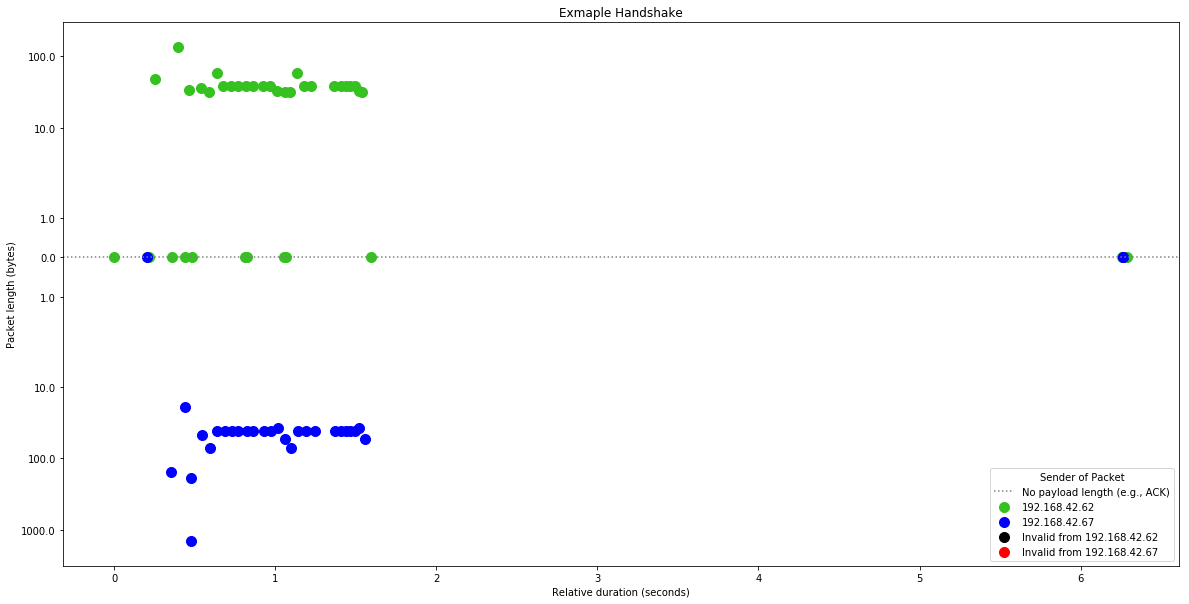

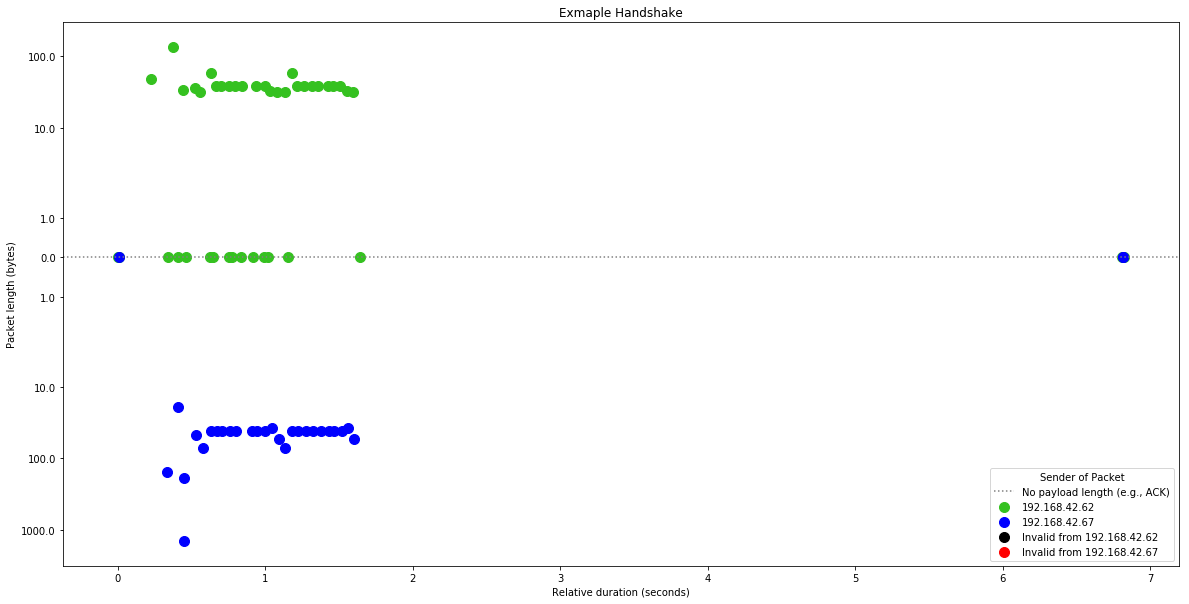

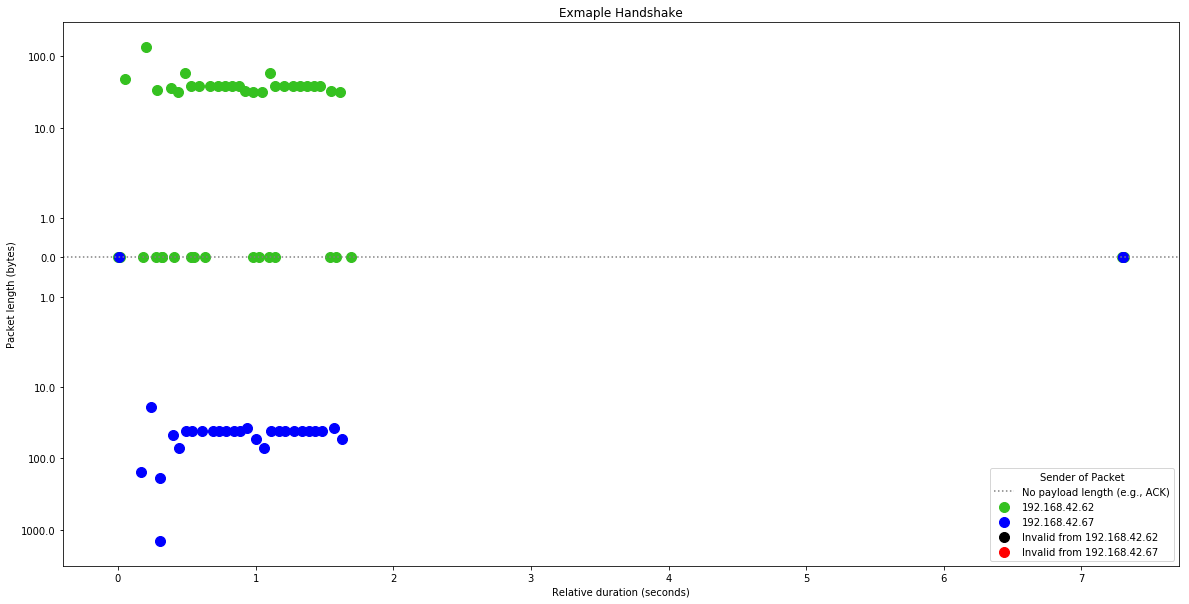

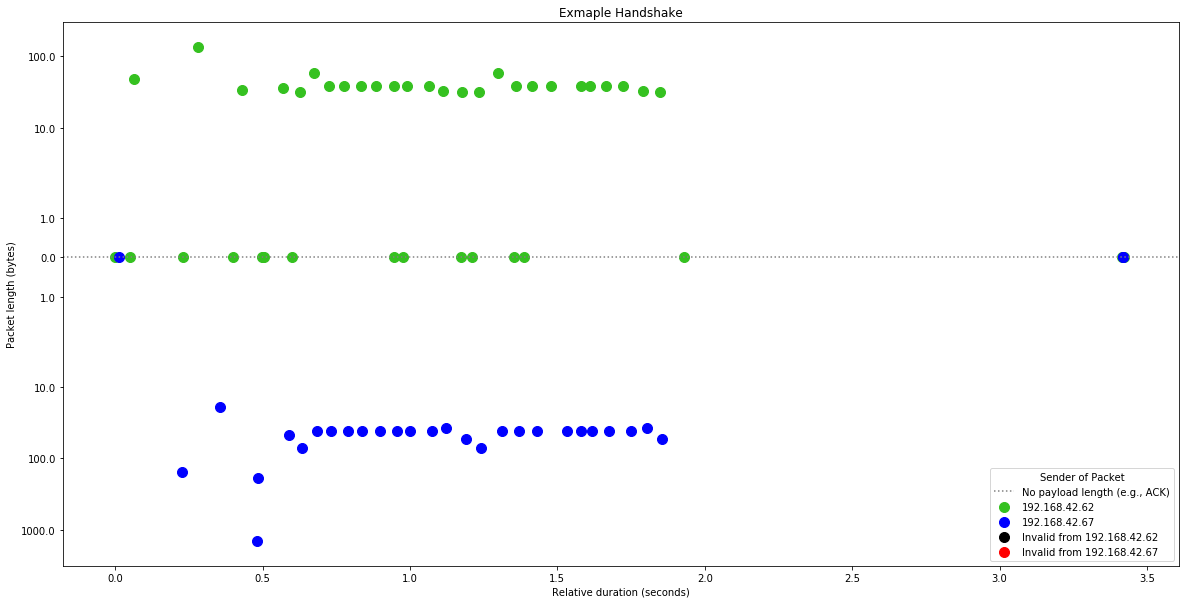

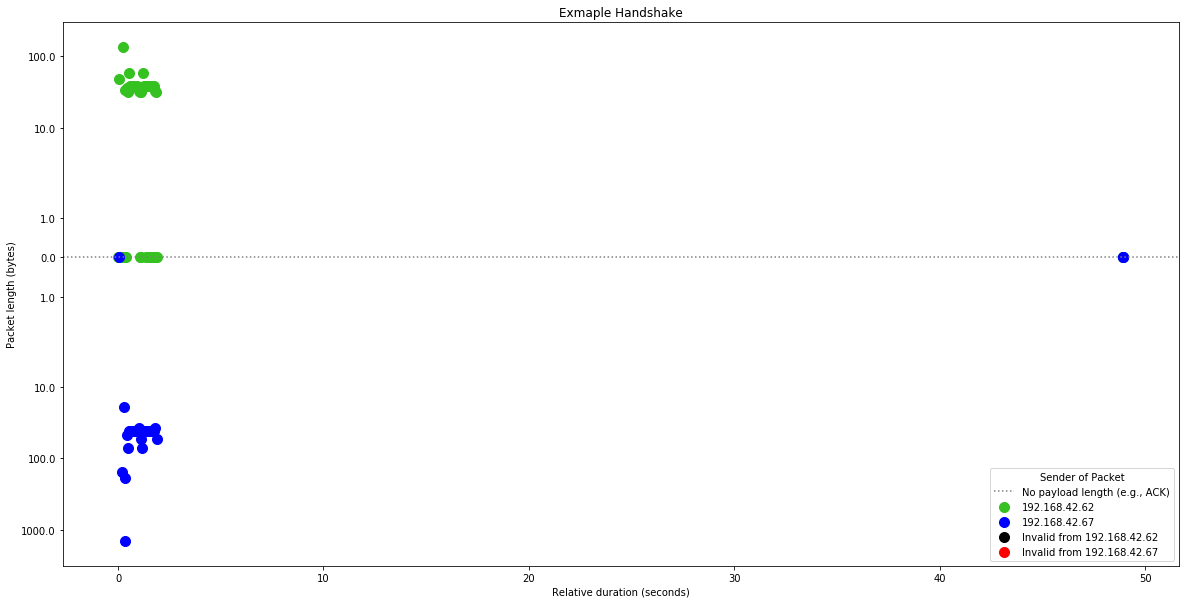

In [6]:
for flow in audit.flow_analyzer.get_tcp_flows():
    fig = plt.figure(figsize=figsize)
    ax = flow.get_packets_graph(draw_highlights=False, highlight_invalid=True)
    ax.set_title('Exmaple Handshake')
    ax.set_yscale('symlog')
    ax.yaxis.set_major_formatter(abs_ticker)
    plt.show()

Now for a capture that does not conform to that policy:

In [7]:
audit = NetAuditor(pdp, './data/captures/DimSlider.json')

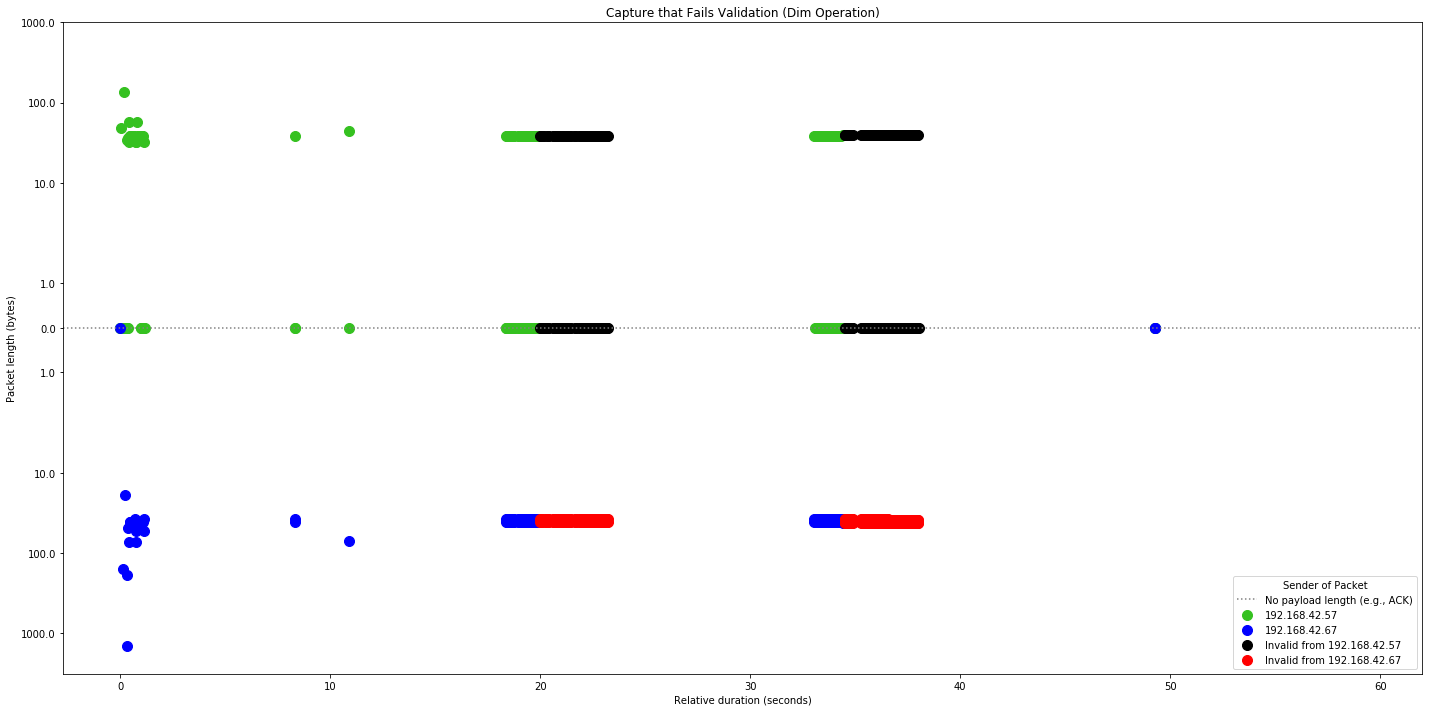

In [8]:
for flow in audit.flow_analyzer.get_tcp_flows():
    fig = plt.figure(figsize=figsize)
    ax = flow.get_packets_graph(draw_highlights=False, highlight_invalid=True)
    ax.set_title('Capture that Fails Validation (Dim Operation)')
    ax.set_yscale('symlog')
    ax.yaxis.set_major_formatter(abs_ticker)
    ax.set_xlim(right=62)
    ax.set_ylim(top=1000)
    fig.tight_layout()
    plt.show()

Example of use of fuzz testing:

In [9]:
fuzzer = InputFuzzer('../captures/switches/IDevicesDimmer/Handshakes/OnlyHandShakes.pcapng')

In [10]:
fuzzed_packets = fuzzer.fuzz()
fuzzed_packets

<PacketList: TCP:508 UDP:0 ICMP:0 Other:0>

In [11]:
wrpcap('./fuzzed_packets.pcap', fuzzed_packets)

!tshark -r ./fuzzed_packets.pcap -T json > ./fuzzed_packets.json

Now we can audit the resulting packets:

In [12]:
audit = NetAuditor(pdp, './fuzzed_packets.json')

In [13]:
flows = audit.flow_analyzer.get_tcp_flows()
flows

[<Flow (192.168.42.57:53152 <--> 192.168.42.62:50008) of 226 packets>,
 <Flow (192.168.42.57:53179 <--> 192.168.42.62:50008) of 60 packets>,
 <Flow (192.168.42.62:50008 <--> 192.168.42.57:53172) of 13 packets>,
 <Flow (192.168.42.57:53138 <--> 192.168.42.62:50008) of 68 packets>,
 <Flow (192.168.42.62:50008 <--> 192.168.42.57:53164) of 69 packets>,
 <Flow (192.168.42.57:53172 <--> 192.168.42.62:50008) of 56 packets>,
 <Flow (192.168.42.57:53179 <--> 192.168.42.62:50008) of 10 packets>,
 <Flow (37.11.2.163:50008 <--> 192.168.42.57:53164) of 1 packets>,
 <Flow (203.86.144.245:53152 <--> 192.168.42.62:50008) of 1 packets>,
 <Flow (192.168.42.62:50008 <--> 67.134.136.27:53172) of 1 packets>,
 <Flow (192.168.42.57:53179 <--> 22.33.176.49:50008) of 1 packets>,
 <Flow (192.168.42.62:50008 <--> 237.127.232.249:53179) of 1 packets>,
 <Flow (230.62.218.152:50008 <--> 192.168.42.57:53152) of 1 packets>]

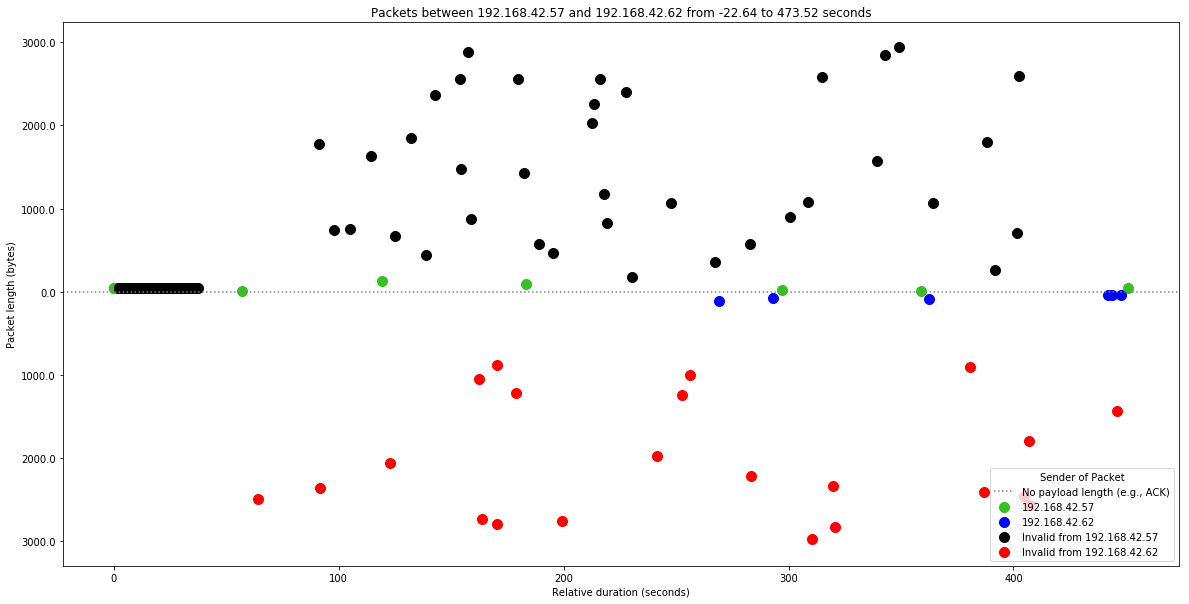

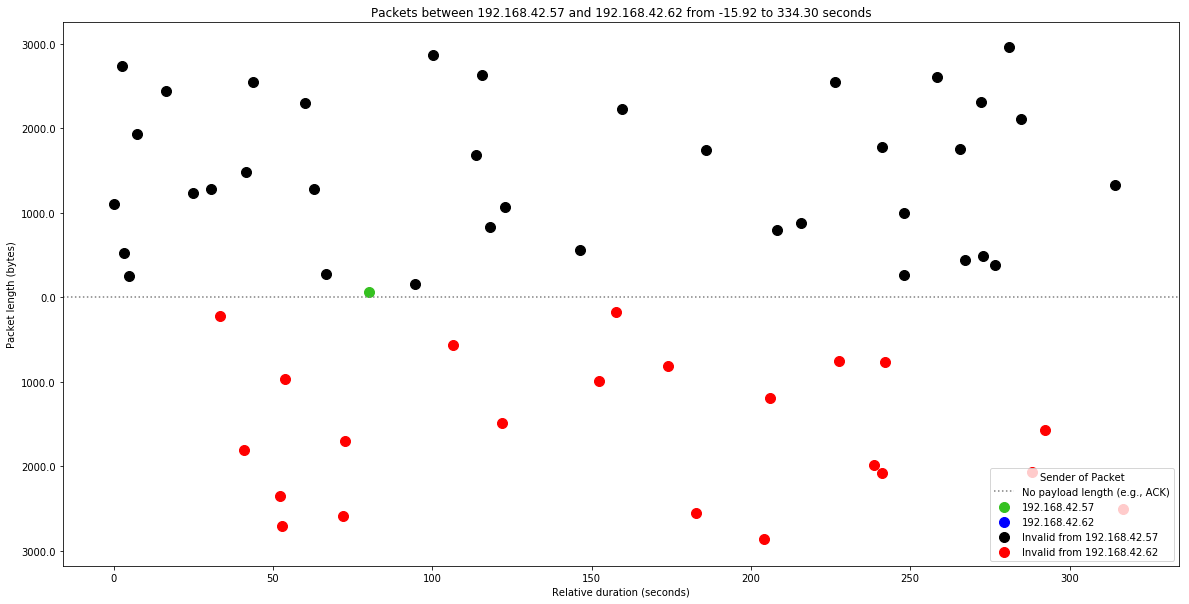

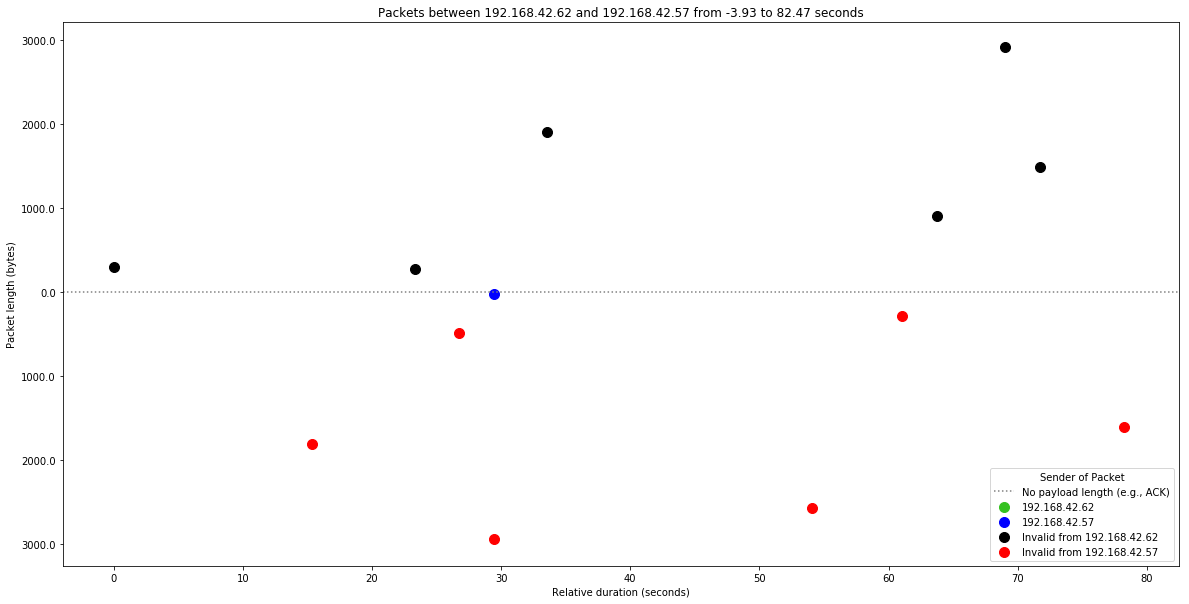

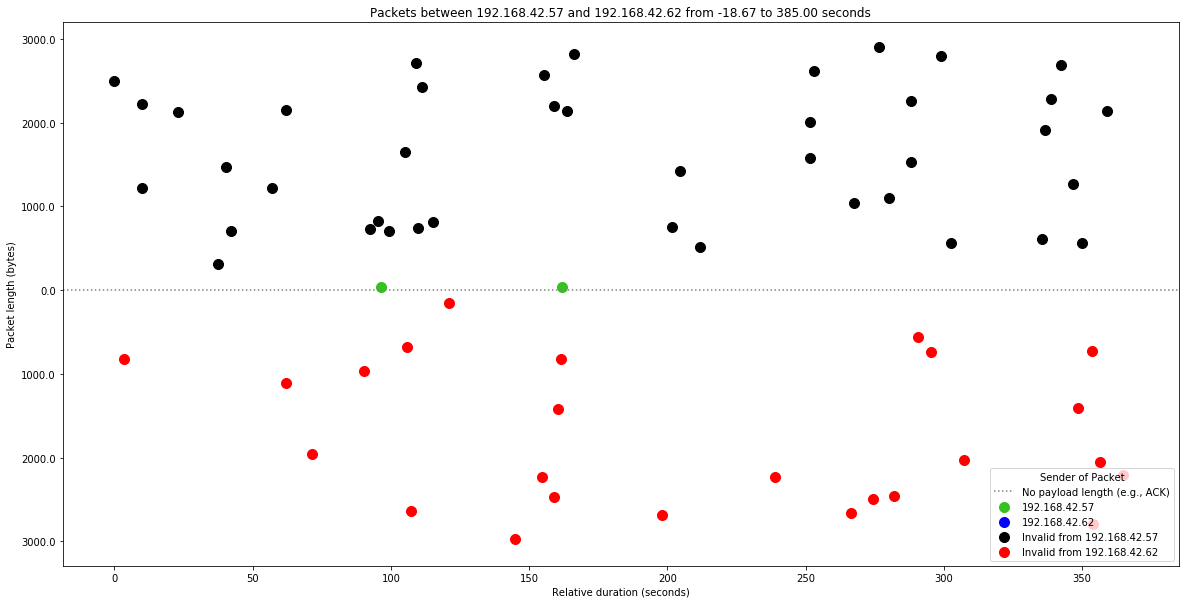

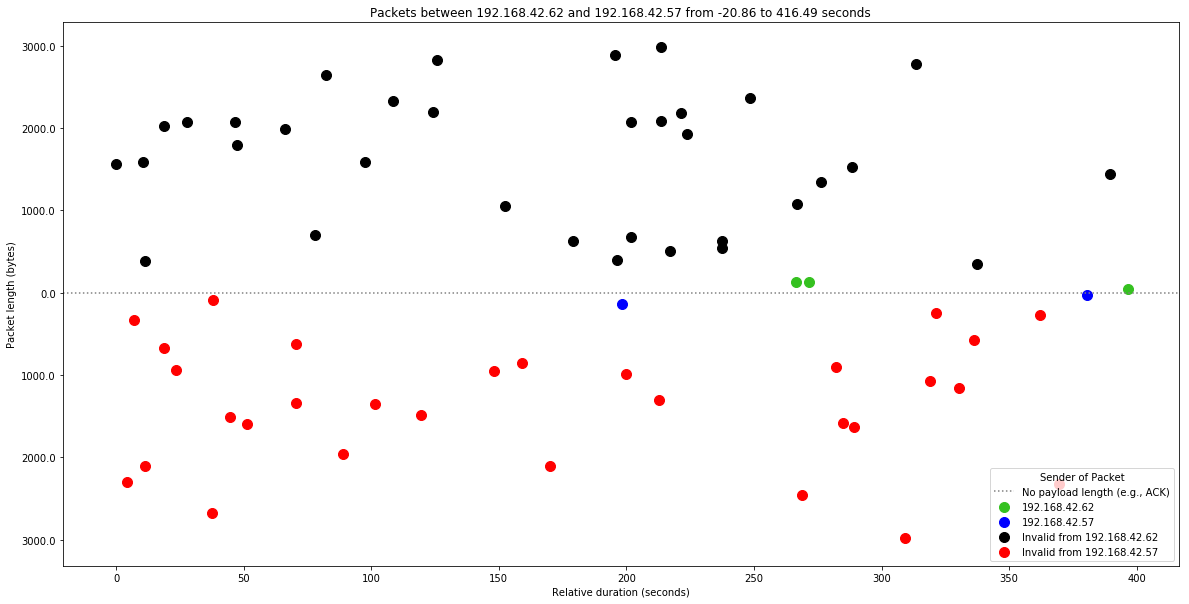

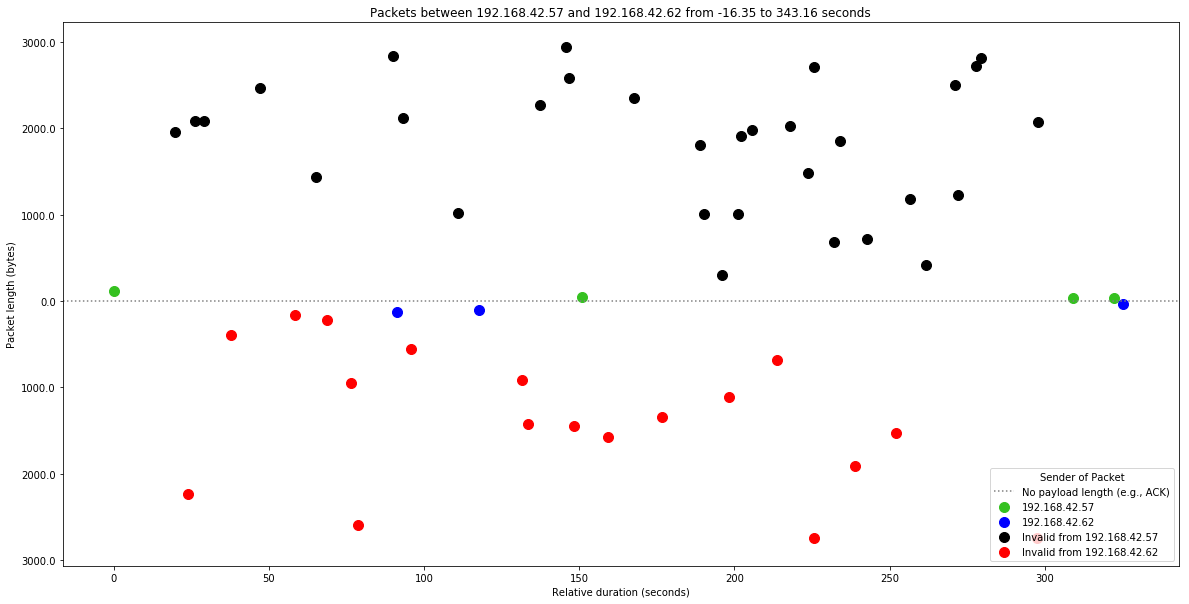

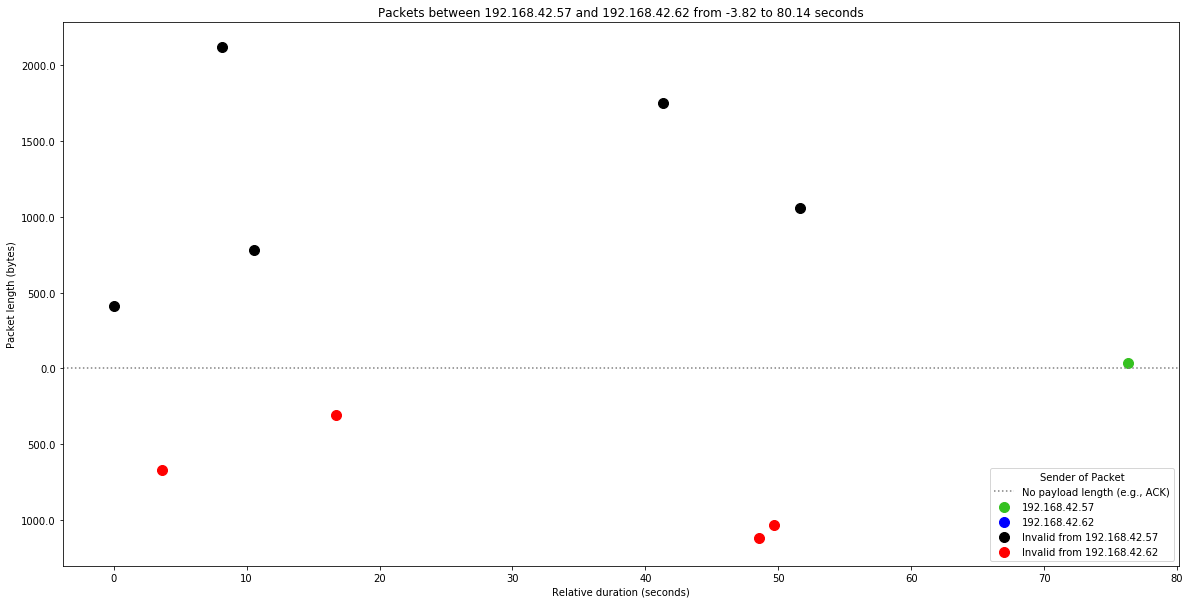

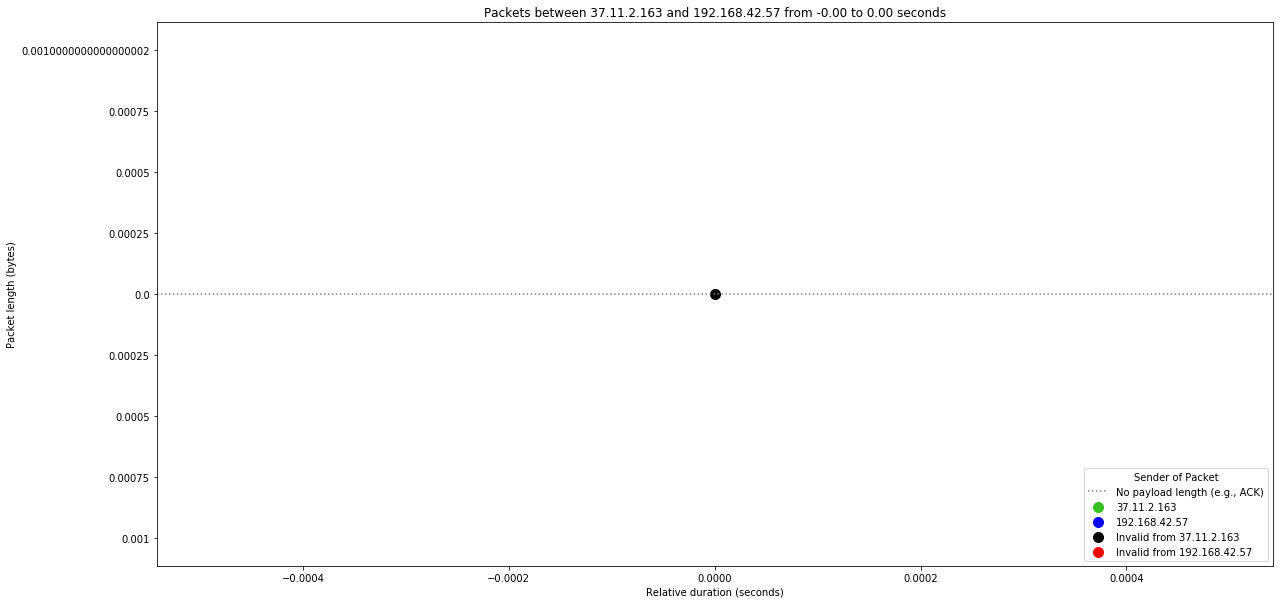

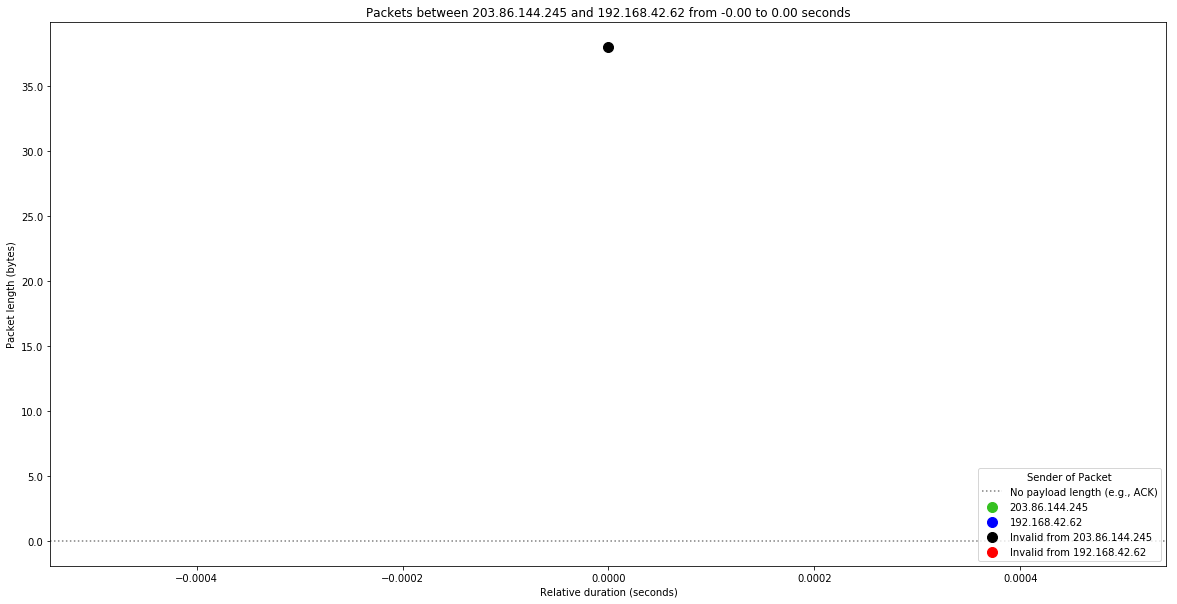

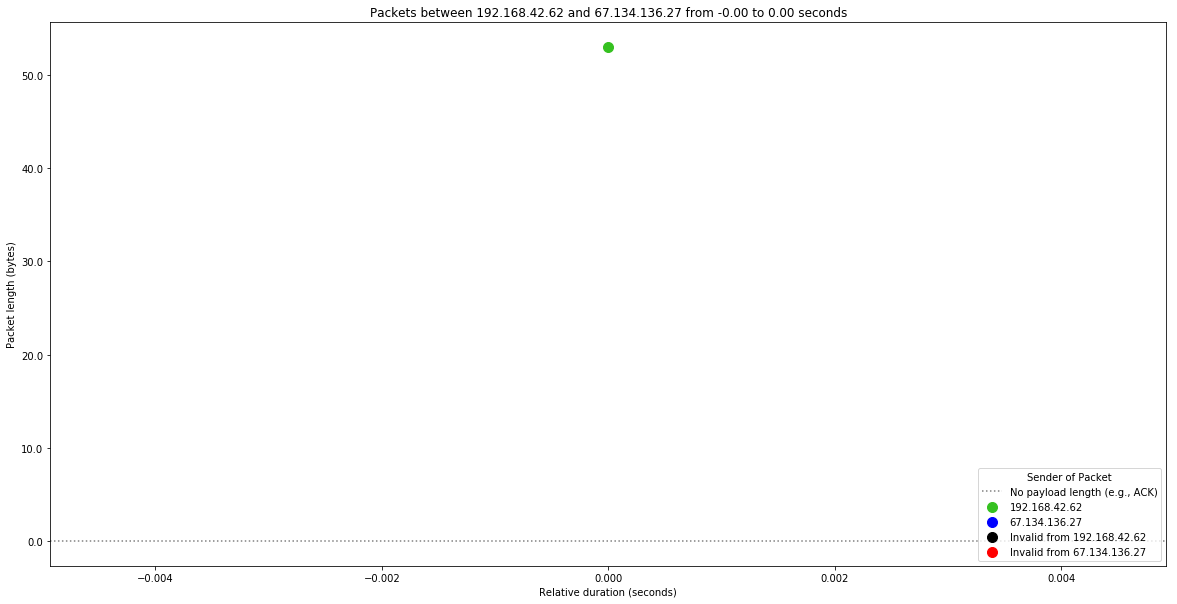

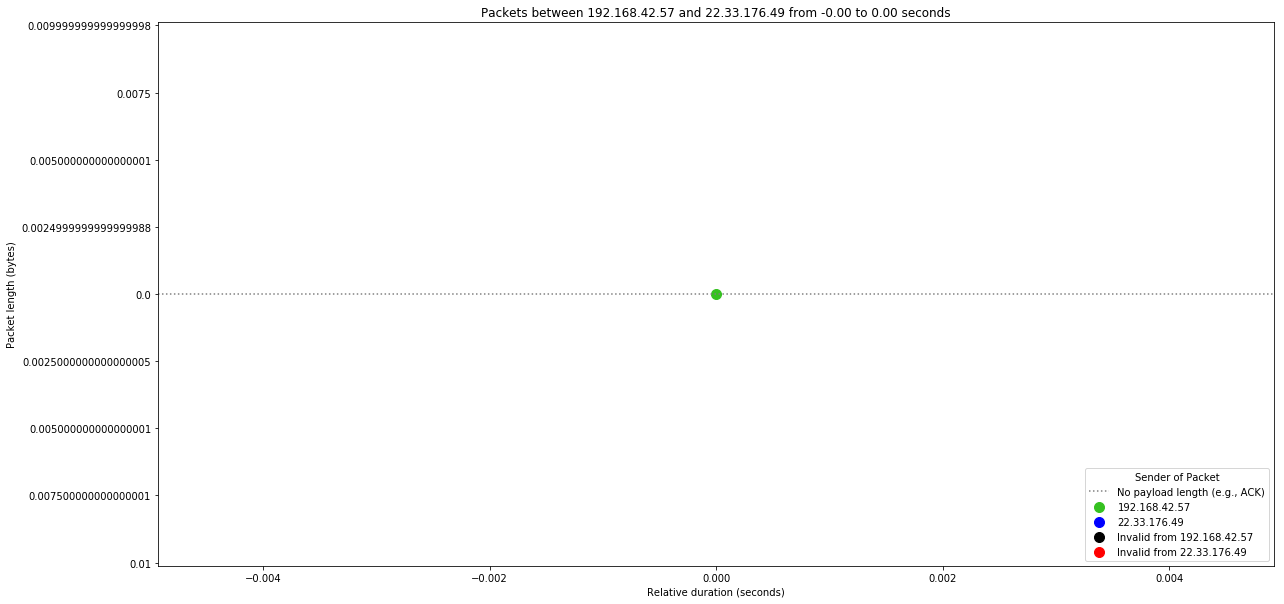

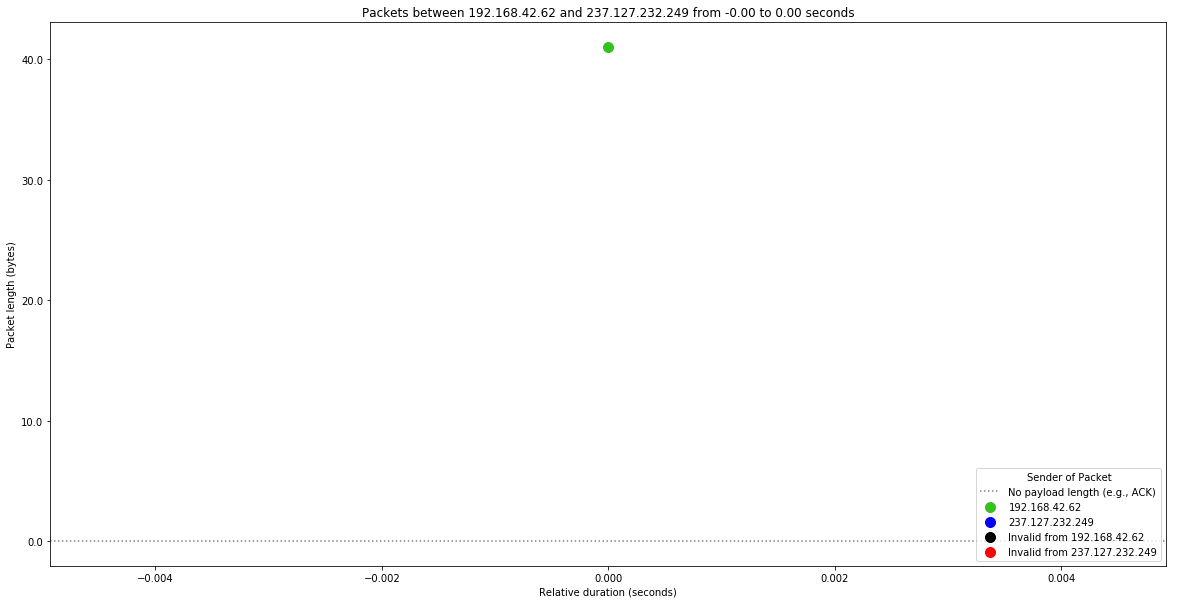

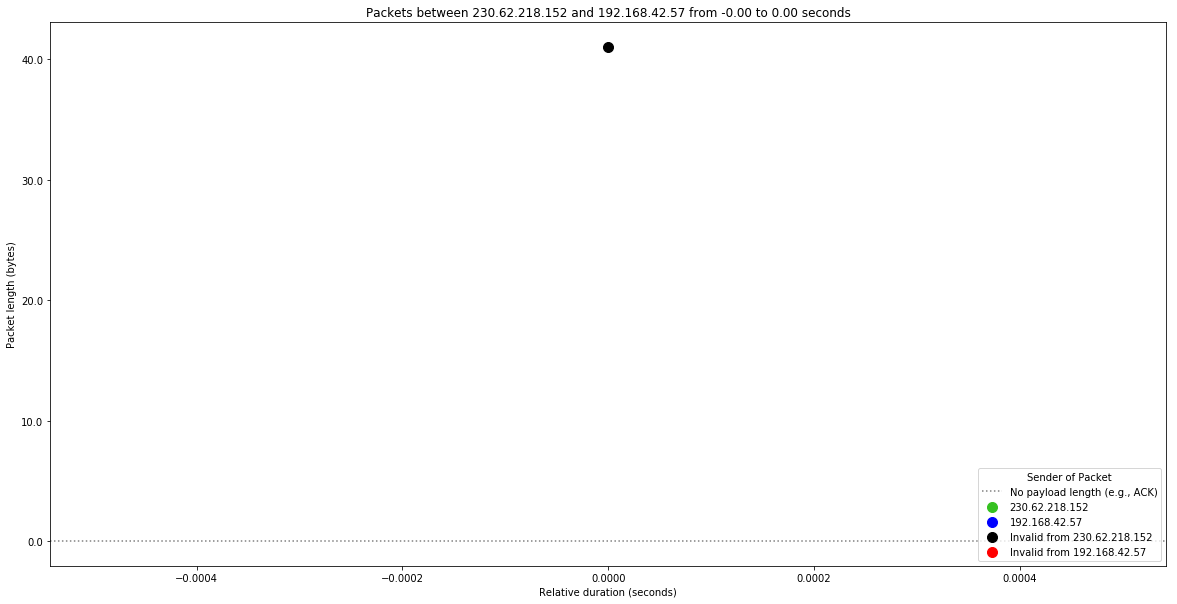

In [14]:
for flow in audit.flow_analyzer.get_tcp_flows():
    fig = plt.figure(figsize=figsize)
    flow.get_packets_graph(draw_highlights=False, highlight_invalid=True)